In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf



Loading and processing the training data

In [2]:
# load the csv file lab, display head to examine
train_file = 'train.csv'
train_csv = pd.read_csv(train_file)
# randomize dataframe rows to prepare for dividing into train/valid/test sets
data = train_csv.sample(frac = 1)
# display for a quick check
data.head()


,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
287,469,Quercus_Coccinea,0.000000,0.000000,0.076172,0.050781,0.007812,0.000000,0.001953,0.0,...,0.000977,0.005859,0.022461,0.001953,0.018555,0.000000,0.017578,0.013672,0.002930,0.009766
149,260,Quercus_Afares,0.011719,0.011719,0.019531,0.013672,0.001953,0.003906,0.029297,0.0,...,0.000000,0.000000,0.000977,0.000000,0.015625,0.000000,0.000000,0.012695,0.046875,0.025391
84,148,Acer_Rufinerve,0.000000,0.000000,0.011719,0.021484,0.046875,0.000000,0.013672,0.0,...,0.055664,0.021484,0.011719,0.005859,0.020508,0.000000,0.000000,0.024414,0.000000,0.003906
315,516,Fagus_Sylvatica,0.025391,0.035156,0.039062,0.013672,0.007812,0.066406,0.080078,0.0,...,0.013672,0.000000,0.005859,0.001953,0.008789,0.001953,0.000000,0.000977,0.000000,0.011719
480,779,Quercus_Ellipsoidalis,0.000000,0.000000,0.050781,0.117190,0.007812,0.000000,0.000000,0.0,...,0.003906,0.006836,0.009766,0.000000,0.014648,0.000000,0.106450,0.001953,0.004883,0.041016


In [3]:
#get the different species categories
categories = train_csv.species.unique()
#print the 1st 10 to verify
print "First 10 categories: ", categories[:10]
#print length of array to ensure 99 categories are there
print "Number of categories:", len(categories) 
print type(categories)

#convert string categories for training set into indices of the categories array
labels_dense = [np.where(i == categories)[0][0] for i in data.species]

#convert dense labels to one-hot-encoding
labels = np.eye(len(categories))[labels_dense]

First 10 categories:  ['Acer_Opalus' 'Pterocarya_Stenoptera' 'Quercus_Hartwissiana'
 'Tilia_Tomentosa' 'Quercus_Variabilis' 'Magnolia_Salicifolia'
 'Quercus_Canariensis' 'Quercus_Rubra' 'Quercus_Brantii' 'Salix_Fragilis']
Number of categories: 99
<type 'numpy.ndarray'>


Split the csv data into training, test, and validation sets

In [4]:
# split into train/test datasets. 
# test here means my own private test set to get my own idea of the accuracy, not the given test set
train_length = int(len(data) * .8)

train_ = data[:train_length]
test_data = data[train_length:]
print("Total data: {} Training and validation examples: {} Test examples: {}".format(len(data), len(train_), len(test_data)))
train_l = labels[:train_length]
test_labels = labels[train_length:]
print("Total labels: {} Training and validation labels: {} Test labelss: {}".format(len(labels), len(train_l), len(test_labels)))

#further split training data and labels into training and validation sets

train_length = int(len(train_) * .8)

train_data = train_[:train_length]
valid_data = train_[train_length:]
print("Total Training and validation examples: {} Training examples: {} Validation examples: {}".format(len(train_), len(train_data), len(valid_data)))
train_labels = train_l[:train_length]
valid_labels = train_l[train_length:]
print("Total Training and validationl labels: {} Training labels: {} Validation labels: {}".format(len(train_l), len(train_labels), len(valid_labels)))
print("Shape of training labels: {}".format(train_labels.shape))

Total data: 990 Training and validation examples: 792 Test examples: 198
Total labels: 990 Training and validation labels: 792 Test labelss: 198
Total Training and validation examples: 792 Training examples: 633 Validation examples: 159
Total Training and validationl labels: 792 Training labels: 633 Validation labels: 159
Shape of training labels: (633, 99)


Now for the image data: I will grab the image for all the ids in the training and test set, coverting them from jpg to binary.

In [5]:
def make_image_set(csv_set):
    images = []
    for i in csv_set.id:
        im_gray = cv2.imread('images/' + str(i) + ".jpg", cv2.IMREAD_GRAYSCALE)
        thres, im_bw = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        im_bw = np.array(im_bw)
        images.append(im_bw)
    return np.array(images)

train_images = make_image_set(train_data)
valid_images = make_image_set(valid_data)
test_images = make_image_set(test_data)

 # conversion to binary courtesy of  http://stackoverflow.com/a/7637687/399741

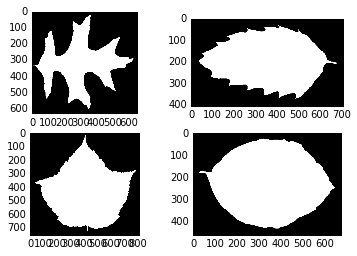

In [6]:
#visualize a few examples, visually verify with images in folder
fig = plt.figure()
counter = 1
for ima in train_images[:4]:
    a = fig.add_subplot(2,2, counter)
    plt.imshow(ima, cmap='gray')
    counter +=1
    

Need to make all the images the same size to run a CNN. Since CNNs are location invariant, preserving image shape is more important than centering it or preserving its location. So I will add black pixeles to the bottom and right edges of the image matrices so that they are of uniform size.

In [31]:
# get the max height and width of all the images in the image dataset
max_height = 0
max_width = 0

for i in images:
    if i.shape[0] > max_height:
        max_height = i.shape[0]
    if i.shape[1] > max_width:
        max_width = i.shape[1]
        
print "Max image height: ", max_height
print "Max image width: ", max_width

# add the padding
def add_padding(image, width, height):
    add_bottom = height - image.shape[0]
    add_right = width - image.shape[1]
    npad = ((0, add_bottom), (0, add_right))
    return np.pad(image, pad_width=npad, mode='constant', constant_values=0)
   
train_images_padded = np.array([add_padding(i, max_width, max_height) for i in train_images])
valid_images_padded = np.array([add_padding(i, max_width, max_height) for i in valid_images])
test_images_padded = np.array([add_padding(i, max_width, max_height) for i in test_images])
print train_images_padded[108].shape

Max image height:  1089
Max image width:  1633
(1089, 1633)


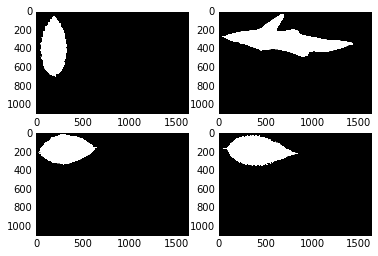

In [32]:
#visualize a few examples, visually verify that padding was added
fig = plt.figure()
counter = 1
for ima in train_images_padded[:4]:
    a = fig.add_subplot(2,2, counter)
    plt.imshow(ima, cmap='gray')
    counter +=1


With all the images the same size, I can now run a CNN. First some useful functions. Much of this code is adapted from TensorFlow.org's tutorial at https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

In [ ]:
# functions to create CNN layers
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

# an accuracy function for testing
#https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/4_convolutions.ipynb   
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Now to create the model graph.

In [ ]:
#placeholders for the inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

#Conv Layer 1
#the weights 
# [patch size, patch size, input channels, output channels]
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

#reshape x to fit a 4d tensor, with the second and third dimensions being image width and height
# final dimension the number of color chanels
x_image = tf.reshape(x, [-1, 28, 28, 1])

#convolving x_image with the weight tensor, add the bias, applly the ReLU function, then max pool
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#Conv Layer 2
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#Densely connected layer
#image size has been reduced to 7x7. We add a fully-connected layer with 1024 units
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#Dropout to reduce overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#Readout layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


Now to train the model.